# Convolutional autoencoder (CAE) for novelty detection
This notebook shows how to use the CAE method for novelty detection for the Mastcam multispectral image dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os

import tensorflow as tf

import datasets
from cae import model

np.random.seed(42)

/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Train the CAE using typical images

Load the training and validation datasets

In [2]:
train_dir = "/home/jovyan/data/train_typical"
val_dir = "/home/jovyan/data/validation_typical"

Some images have a black stripe (image artifact) on the side. We want to remove these images from the dataset since they are not a "typical" feature in Mastcam images of the Mars surface.

In [3]:
train_data, train_names = datasets.load_6f_images(train_dir, shuffle=True, remove_striped=True)
val_data, val_names = datasets.load_6f_images(val_dir, shuffle=True, remove_striped=True)

('Loaded dataset with shape:', (9124, 64, 64, 6))
('Loaded dataset with shape:', (1374, 64, 64, 6))


Augment training data with horizontal flips

In [4]:
train_data_aug = np.ndarray([train_data.shape[0]*2, train_data.shape[1],train_data.shape[2],train_data.shape[3]])
for i in range(train_data.shape[0]):
    hflip = np.fliplr(train_data[i])
    train_data_aug[train_data.shape[0]+i] = hflip
    train_names.append(train_names[i])
print('Augmented training data size: %d' % train_data_aug.shape[0])

Augmented training data size: 18248


In [5]:
# Shuffle the training data again
np.random.shuffle(train_data_aug)

In [6]:
train_data = train_data_aug

Load the convolutional autoencoder model (see model.py for architecture details). 

The options for loss are 'mse' (mean squared error), 'ssim' (structural similarity index), and 'hybrid' (a combination of mse and ssim). If 'hybrid' loss is used, you must provide an additional argument (hybrid_lambda) for the weighting factor on MSE.

In [7]:
# Load the convolutional autoencoder model with desired loss function
ae = model.autoencoder(input_shape=[None, 64, 64, 6], loss='mse')

(?, 16, 16, 3)


In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, epsilon=1.0).minimize(ae['cost'])

In [9]:
# Create a TF session and initialize global variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
# Define training hyperparameters
np.random.seed(42)
batch_size = 100
num_batches = train_data.shape[0] / batch_size

# Train model until convergence
n_epochs = 40
prev_loss = 10000000
val_losses = []

for epoch in range(n_epochs):
    # Fit model to full training dataset
    %time
    for batch_i in range(num_batches):
        idx = batch_i*batch_size
        batch_xs = train_data[idx:idx+batch_size]
        sess.run(optimizer, feed_dict={ae['x']: batch_xs, ae['keep_prob']: 0.6})
        train_loss = sess.run(ae['merged'], feed_dict={ae['x']: batch_xs, ae['keep_prob']: 0.6})
    # Compute metrics after each epoch
    val_loss = sess.run(ae['merged'], feed_dict={ae['x']: val_data, ae['keep_prob']: 1.0})
    loss = sess.run(ae['cost'], feed_dict={ae['x']: val_data, ae['keep_prob']: 1.0})
    print('Validation loss at Epoch %d (delta=%f)' % (epoch, prev_loss - loss), loss)
    prev_loss = loss
    val_losses.append(loss)

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 19.1 µs
('Validation loss at Epoch 0 (delta=9999425.202209)', 574.7978)
('Validation loss at Epoch 1 (delta=226.334686)', 348.4631)
('Validation loss at Epoch 2 (delta=79.585449)', 268.87766)
('Validation loss at Epoch 3 (delta=47.996460)', 220.8812)
('Validation loss at Epoch 4 (delta=28.690628)', 192.19057)
('Validation loss at Epoch 5 (delta=19.466293)', 172.72427)
('Validation loss at Epoch 6 (delta=13.469009)', 159.25526)
('Validation loss at Epoch 7 (delta=9.330460)', 149.9248)
('Validation loss at Epoch 8 (delta=7.343384)', 142.58142)
('Validation loss at Epoch 9 (delta=5.217606)', 137.36382)
('Validation loss at Epoch 10 (delta=4.089722)', 133.2741)
('Validation loss at Epoch 11 (delta=4.859756)', 128.41434)
('Validation loss at Epoch 12 (delta=5.368988)', 123.04535)
('Validation loss at Epoch 13 (delta=8.650520)', 114.39483)
('Validation loss at Epoch 14 (delta=13.374924)', 101.019905)
('Validation loss at Epoch 15 (delta

Plot the validation loss

Text(0,0.5,'Validation loss')

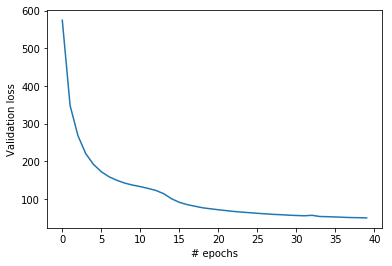

In [11]:
plt.plot(range(n_epochs), val_losses)
plt.xlabel('# epochs')
plt.ylabel('Validation loss')

## 2. Reconstruct test data using CAE trained on typical images

While the CAE is trained on only typical images, we test the novelty detection performance using both typical and novel images. Thus in this step we create reconstructions of input images using the CAE for both the novel and typical test datasets.

In [12]:
test_dir_typical = "/home/jovyan/data/test_typical"

In [13]:
test_data_typical, test_names_typical = datasets.load_6f_images(test_dir_typical, shuffle=False, remove_striped=True)

('Loaded dataset with shape:', (420, 64, 64, 6))


In [14]:
# Get the reconstructions using the trained model
def get_recons(data):
    n = 5
    batch_size = data.shape[0] // n
    recon = np.ndarray(data.shape)
    encoded = np.ndarray([data.shape[0], 16, 16, 3])
    for i in range(n):
        if i == n-1:
            batch_x = data[i*batch_size:]
            recon[i*batch_size:] = sess.run(ae['y'], feed_dict={ae['x']: batch_x})
            encoded[i*batch_size:] = sess.run(ae['z'], feed_dict={ae['x']: batch_x})
        else:
            batch_x = data[i*batch_size:i*batch_size+batch_size]
            recon[i*batch_size:i*batch_size+batch_size] = sess.run(ae['y'], feed_dict={ae['x']: batch_x})
            encoded[i*batch_size:i*batch_size+batch_size] = sess.run(ae['z'], feed_dict={ae['x']: batch_x})
    return recon, encoded

Get CAE reconstructions for typical test data

In [15]:
recon_typical, _ = get_recons(test_data_typical)

Get CAE reconstructions for images in each sub-category of novelty as well as the entire novel dataset

In [16]:
test_dir_novel = "/home/jovyan/data/test_novel"

In [17]:
recon_novel = {}
input_novel = {}
novel_categories = ['all', 'bedrock', 'broken-rock', 'drill-hole', 'drt', 'dump-pile', 'float', 'meteorite', 'veins']
for cat in novel_categories:
    # Load the dataset
    data, names = datasets.load_6f_images(os.path.join(test_dir_novel, cat), shuffle=False, remove_striped=True)
    input_novel[cat] = data
    recon_novel[cat], _ = get_recons(data)

('Loaded dataset with shape:', (430, 64, 64, 6))
('Loaded dataset with shape:', (11, 64, 64, 6))
('Loaded dataset with shape:', (76, 64, 64, 6))
('Loaded dataset with shape:', (62, 64, 64, 6))
('Loaded dataset with shape:', (111, 64, 64, 6))
('Loaded dataset with shape:', (93, 64, 64, 6))
('Loaded dataset with shape:', (18, 64, 64, 6))
('Loaded dataset with shape:', (34, 64, 64, 6))
('Loaded dataset with shape:', (30, 64, 64, 6))


## 3. Compute novelty scores for test data

Novelty scores are computed using the input and reconstructed images. We used two different novelty scores: l2 loss and outlier count. Both functions are provided below; see paper for which score to use with which method/CAE loss.

In [18]:
def l2(batch1, batch2):
    l2_norm = np.ndarray(batch1.shape[0])
    for i in range(batch1.shape[0]):
        flat_diff = batch1[i].flatten() - batch2[i].flatten()
        l2_norm[i] = np.linalg.norm(flat_diff, ord=2)
    return l2_norm

def outliers(batch1, batch2):
    num_outliers = np.ndarray(batch1.shape[0])
    for i in range(batch1.shape[0]):
        errormap = np.square(batch1[i]-batch2[i])
        mu = np.mean(errormap)
        std = np.std(errormap)
        outlier_inds = np.where(errormap.flatten() > mu)[0]
        num_outliers[i] = len(outlier_inds)
    return num_outliers

Get the scores for the typical test data

In [19]:
scores_typical = l2(test_data_typical, recon_typical)

Get the scores for each sub-category of novelty as well as the entire novel dataset

In [20]:
scores_novel = {}
for cat in recon_novel.keys():
    scores_novel[cat] = l2(input_novel[cat], recon_novel[cat])

Plot the distribution of novelty scores for each class

Text(0,0.5,'Density')

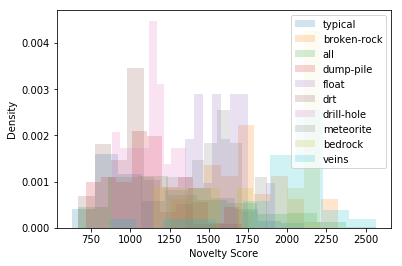

In [21]:
plt.hist(scores_typical, alpha=0.2, label='typical', density=True)
for cat in scores_novel.keys():
    plt.hist(scores_novel[cat], alpha=0.2, label=cat, density=True)
plt.legend()
plt.xlabel('Novelty Score')
plt.ylabel('Density')

## 4. Evaluate CAE performance for novelty detection

We used two metrics for quantitatively evaluating performance: area under the curve (AUC) of the receiver operator characteristic (ROC) curve and precision at N. Precision at N is the fraction of correct classifications in the top N images when sorted by novelty score (i.e., the fraction of novel images in the top N test images sorted by novelty score).

### Compute AUC scores

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

Text(0.5,0,'True positive rate')

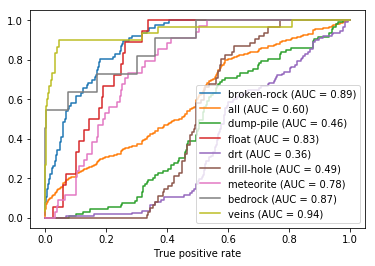

In [23]:
for cat in scores_novel.keys():
    scores = np.concatenate([scores_typical, scores_novel[cat]])
    labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel[cat].shape)])
    fpr, tpr, thresholds = roc_curve(y_true=labels, y_score=scores)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (cat, auc_score))
plt.legend()
plt.xlabel("False positive rate")
plt.xlabel("True positive rate")

### Compute Precision at N

Sort the combined test dataset (novel and typical images) by their novelty score

In [25]:
test_data_novel, test_names_novel = datasets.load_6f_images(os.path.join(test_dir_novel, 'all'), shuffle=False, remove_striped=True)

('Loaded dataset with shape:', (430, 64, 64, 6))


In [26]:
combined_scores = np.concatenate([scores_typical, scores_novel['all']])

In [27]:
combined_labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel['all'].shape)])

In [28]:
combined_inputs = np.concatenate([test_data_typical, test_data_novel])

In [29]:
combined_names = np.concatenate([test_names_typical, test_names_novel])

In [30]:
# Sort the scores, labels, filenames, and inputs by novelty score 
sorted_scores = sorted(zip(combined_scores, combined_labels, combined_names, combined_inputs), key=lambda tup: tup[0], reverse=True)
combined_scores, combined_labels, combined_names, combined_inputs = zip(*sorted_scores)

Compute Precision at N for the top-ranked images

In [43]:
# Choose the top N
N = 10
top_scores = combined_scores[:N]
top_labels = combined_labels[:N]
top_names = combined_names[:N]
top_images = combined_inputs[:N]

Precision at N=10: 0.900000


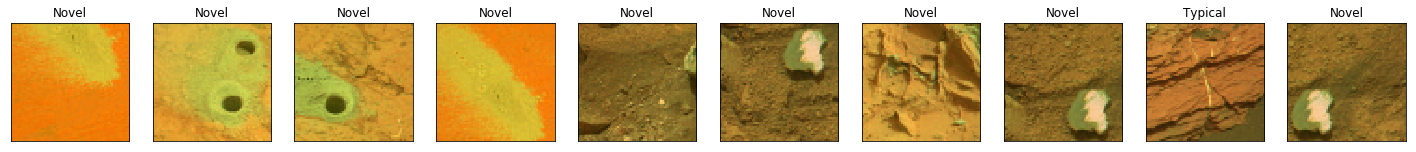

In [44]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(top_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if top_labels[i] == 0:
        axes[i].set_title('Typical')
    elif top_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(top_labels) == 1)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))

### Compute False Negatives at N

False Negatives at N is the fraction of novel images that appear in the bottom N images when ranked by novelty score.

In [45]:
# Choose the bottom N
bottom_scores = combined_scores[-N:]
bottom_labels = combined_labels[-N:]
bottom_names = combined_names[-N:]
bottom_images = combined_inputs[-N:]

Precision at N=10: 1.000000


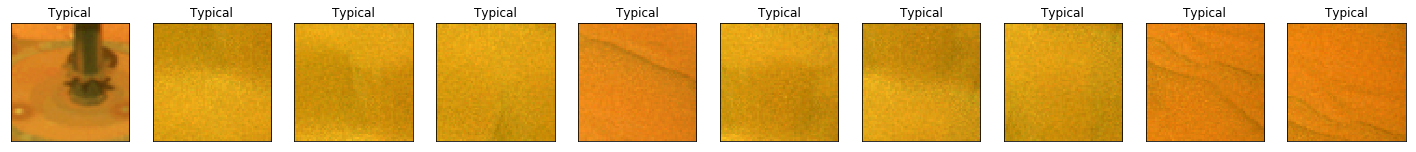

In [46]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(bottom_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if bottom_labels[i] == 0:
        axes[i].set_title('Typical')
    elif bottom_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(bottom_labels) == 0)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))